In [349]:
import numpy as np 
import pandas as pd 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from pycaret.classification import *

# from tpot import TPOTClassifier

import seaborn as sns 
import matplotlib.pyplot as plt

import warnings

ModuleNotFoundError: No module named 'imp'

In [307]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### Загрузка, подготовка данных по условию

In [308]:
DTP_FILE_PATH = './DataDTPкор.xlsx'
POGODA_FILE_PATH = './Pogoda.xlsx'

df_dtp = pd.read_excel(DTP_FILE_PATH)  
df_pogoda = pd.read_excel(POGODA_FILE_PATH)  

In [309]:
df_dtp.shape

(35019, 15)

In [310]:
df_pogoda.shape

(279935, 12)

In [311]:
df = pd.merge(left=df_pogoda, right=df_dtp, on='join_key', how='left')

df.shape

(286662, 26)

In [312]:
def to_snake_case(string):
    return string.lower().replace(' ', '_')

df.rename(columns=lambda c: to_snake_case(c), inplace=True)

### Выбор по Северной части

In [313]:
df['region_x'].isna().sum()

0

In [314]:
df['region_x'].unique()

array(['Восток', 'Запад', 'Север', 'Северо-восток', 'Северо-запад',
       'Центр', 'Юг', 'Юго-восток', 'Юго-запад'], dtype=object)

In [315]:
def is_north(value):
    return value.upper().split('СЕВЕР')[0] == ''

is_north('Север'), is_north('Северо-восток'), is_north('Северо-запад')

(True, True, True)

In [316]:
df = df[df['region_x'].apply(lambda v: is_north(v))]

df['region_x'].unique()

array(['Север', 'Северо-восток', 'Северо-запад'], dtype=object)

### Этап EDA

In [317]:
df.shape

(46786, 26)

In [318]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46786 entries, 31939 to 78724
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   join_key               46786 non-null  object        
 1   datetime_x             46786 non-null  object        
 2   year                   46786 non-null  int64         
 3   month                  46786 non-null  int64         
 4   region_x               46786 non-null  object        
 5   temperature            46783 non-null  float64       
 6   atmospheric_pressure   46783 non-null  float64       
 7   humidity               46783 non-null  float64       
 8   direction_of_the_wind  46786 non-null  object        
 9   wind_speed             46783 non-null  float64       
 10  cloudiness             46786 non-null  float64       
 11  weather_conditions     46786 non-null  object        
 12  datetime_round         12206 non-null  datetime64[ns]
 13  id

In [319]:
df.drop_duplicates(inplace=True)

In [320]:
df.isna().mean()*100

join_key                  0.000000
datetime_x                0.000000
year                      0.000000
month                     0.000000
region_x                  0.000000
temperature               0.006415
atmospheric_pressure      0.006415
humidity                  0.006415
direction_of_the_wind     0.000000
wind_speed                0.006415
cloudiness                0.000000
weather_conditions        0.000000
datetime_round           73.908953
id                       73.908953
light                    73.908953
point                    73.908953
pogoda_region            73.908953
region_y                 73.908953
address                  75.658049
category                 73.908953
datetime_y               73.908953
severity                 73.908953
dead_count               73.908953
injured_count            73.908953
parent_region            73.908953
participants_count       73.908953
dtype: float64

In [321]:
# Заполним численные признаки медианой 
df['temperature'].fillna(df['temperature'].median(), inplace=True)
df['atmospheric_pressure'].fillna(df['atmospheric_pressure'].median(), inplace=True)
df['humidity'].fillna(df['humidity'].median(), inplace=True)
df['wind_speed'].fillna(df['wind_speed'].median(), inplace=True)

In [322]:
df['datetime_x'] = pd.to_datetime(df['datetime_x'])

In [323]:
df.isna().mean()*100

join_key                  0.000000
datetime_x                0.000000
year                      0.000000
month                     0.000000
region_x                  0.000000
temperature               0.000000
atmospheric_pressure      0.000000
humidity                  0.000000
direction_of_the_wind     0.000000
wind_speed                0.000000
cloudiness                0.000000
weather_conditions        0.000000
datetime_round           73.908953
id                       73.908953
light                    73.908953
point                    73.908953
pogoda_region            73.908953
region_y                 73.908953
address                  75.658049
category                 73.908953
datetime_y               73.908953
severity                 73.908953
dead_count               73.908953
injured_count            73.908953
parent_region            73.908953
participants_count       73.908953
dtype: float64

Обратим внимание на пропуски в dead_count и injured_count. Возможно, они означают, что смертей и травм не было, следовательно записи об этом могло и не быть             

In [324]:
df['dead_count'].unique(), df['injured_count'].unique()

(array([nan,  0.,  1.,  3.,  2.]),
 array([nan,  1.,  4.,  2.,  3.,  0.,  5.,  7.,  6., 12.]))

In [325]:
df['dead_count'].fillna(0, inplace=True)
df['injured_count'].fillna(0, inplace=True)

In [326]:
df[df.isnull().any(axis=1)]

,join_key,datetime_x,year,month,region_x,temperature,atmospheric_pressure,humidity,direction_of_the_wind,wind_speed,...,pogoda_region,region_y,address,category,datetime_y,severity,dead_count,injured_count,parent_region,participants_count
31939,Север42736,2017-01-01 00:00:00,2017,1,Север,0.9,755.2,96.0,ЗЮЗ,1.0,...,NaN,NaN,NaN,NaN,NaT,NaN,0.0,0.0,NaN,NaN
31941,"Север42736,125",2017-01-01 03:00:00,2017,1,Север,1.3,754.3,96.0,З,2.0,...,NaN,NaN,NaN,NaN,NaT,NaN,0.0,0.0,NaN,NaN
31943,"Север42736,25",2017-01-01 06:00:00,2017,1,Север,1.3,753.0,97.0,З,2.0,...,NaN,NaN,NaN,NaN,NaT,NaN,0.0,0.0,NaN,NaN
31945,"Север42736,375",2017-01-01 09:00:00,2017,1,Север,1.6,752.7,96.0,З,1.0,...,NaN,NaN,NaN,NaN,NaT,NaN,0.0,0.0,NaN,NaN
31953,"Север42736,75",2017-01-01 18:00:00,2017,1,Север,1.7,751.0,96.0,ЗЮЗ,1.0,...,NaN,NaN,NaN,NaN,NaT,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78720,"Северо-запад44561,375",2021-12-31 09:00:00,2021,12,Северо-запад,-6.3,759.3,89.0,СЗ,1.0,...,NaN,NaN,NaN,NaN,NaT,NaN,0.0,0.0,NaN,NaN
78721,"Северо-запад44561,5",2021-12-31 12:00:00,2021,12,Северо-запад,-5.2,758.1,86.0,ЮЮВ,1.0,...,NaN,NaN,NaN,NaN,NaT,NaN,0.0,0.0,NaN,NaN
78722,"Северо-запад44561,625",2021-12-31 15:00:00,2021,12,Северо-запад,-4.6,756.5,84.0,ЮВ,1.0,...,NaN,NaN,NaN,NaN,NaT,NaN,0.0,0.0,NaN,NaN
78723,"Северо-запад44561,75",2021-12-31 18:00:00,2021,12,Северо-запад,-4.5,755.3,89.0,ЮВ,1.0,...,NaN,NaN,NaN,NaN,NaT,NaN,0.0,0.0,NaN,NaN


In [327]:
DROP_PERCENTAGE = 65

na_features = df.isna().mean()*100
na_features = na_features.loc[na_features >= DROP_PERCENTAGE].index

df.drop(na_features, axis=1, inplace=True)

In [328]:
df.head(5)

,join_key,datetime_x,year,month,region_x,temperature,atmospheric_pressure,humidity,direction_of_the_wind,wind_speed,cloudiness,weather_conditions,dead_count,injured_count
31939,Север42736,2017-01-01 00:00:00,2017,1,Север,0.9,755.2,96.0,ЗЮЗ,1.0,1.0,Дымка.,0.0,0.0
31941,"Север42736,125",2017-01-01 03:00:00,2017,1,Север,1.3,754.3,96.0,З,2.0,1.0,Дымка.,0.0,0.0
31943,"Север42736,25",2017-01-01 06:00:00,2017,1,Север,1.3,753.0,97.0,З,2.0,1.0,Дымка.,0.0,0.0
31945,"Север42736,375",2017-01-01 09:00:00,2017,1,Север,1.6,752.7,96.0,З,1.0,1.0,Дымка.,0.0,0.0
31947,"Север42736,5",2017-01-01 12:00:00,2017,1,Север,1.9,752.4,96.0,ЗЮЗ,2.0,1.0,Морось незамерзающая непрерывная слабая в срок...,0.0,1.0


#### Удаление выбросов и аномалий

In [329]:
df.shape

(46767, 14)

In [330]:
num_features = ['temperature', 'atmospheric_pressure', 'humidity', 'wind_speed', 'cloudiness', 'dead_count', 'injured_count']

df_anomaly = df[num_features]

df_anomaly.head(5)

,temperature,atmospheric_pressure,humidity,wind_speed,cloudiness,dead_count,injured_count
31939,0.9,755.2,96.0,1.0,1.0,0.0,0.0
31941,1.3,754.3,96.0,2.0,1.0,0.0,0.0
31943,1.3,753.0,97.0,2.0,1.0,0.0,0.0
31945,1.6,752.7,96.0,1.0,1.0,0.0,0.0
31947,1.9,752.4,96.0,2.0,1.0,0.0,1.0


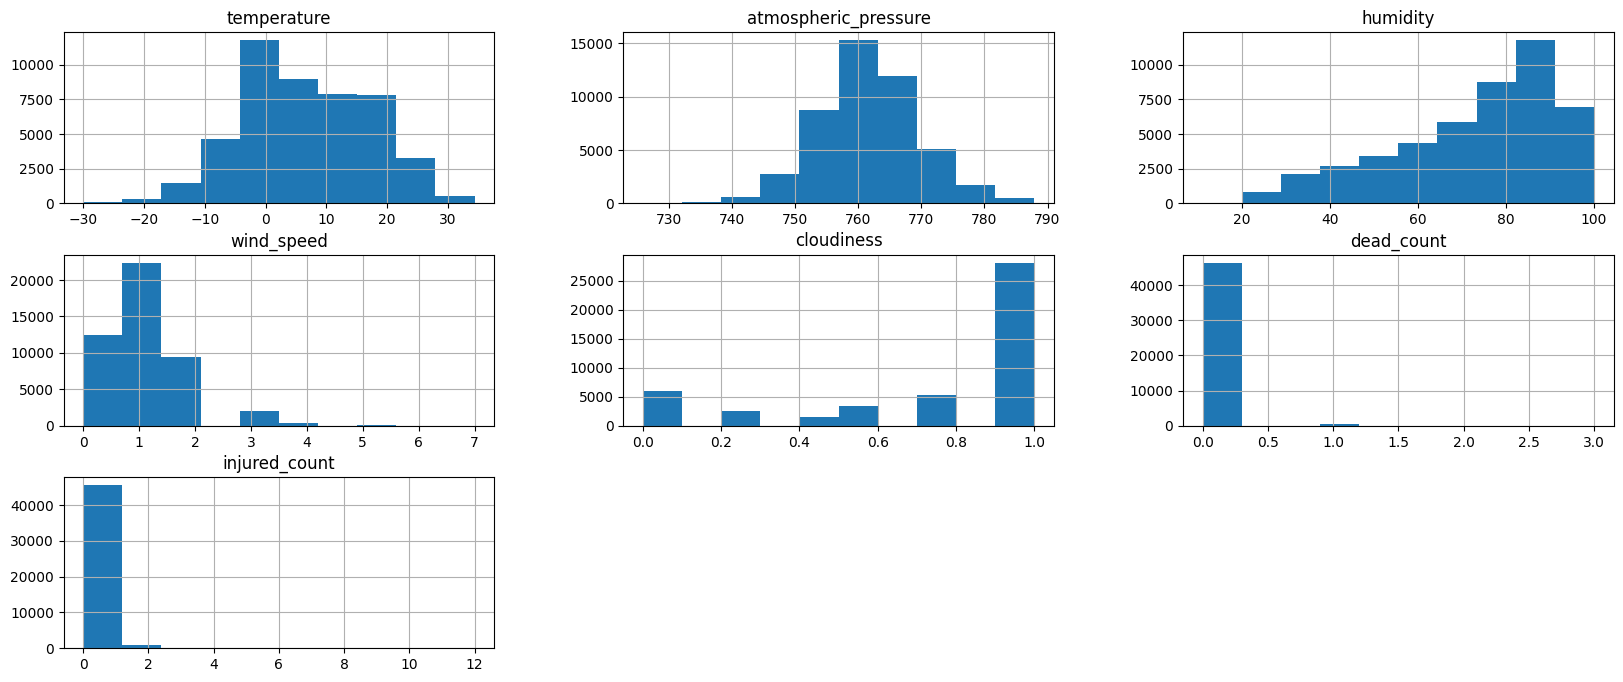

In [331]:
df_anomaly.hist(figsize=(20, 8))

plt.show()

In [332]:
def is_out_std(df, column):
    lim = 3
    
    mean = df[column].mean()
    std = df[column].std()
    
    top = mean + lim * std
    bottom = mean - lim * std 
    
    anomalies = pd.concat([df[column] > top, df[column] < bottom], axis=1).any(axis=1)
    
    return anomalies

In [333]:
df_anomaly_check = pd.DataFrame(is_out_std(df[num_features], num_features), columns=['is_anomaly'])

In [334]:
drop_indexes = df_anomaly_check[df_anomaly_check['is_anomaly'] == True].T.columns # Можно убрать == True, но для большей понятности

df.drop(drop_indexes, inplace=True)

df.shape

(44440, 14)

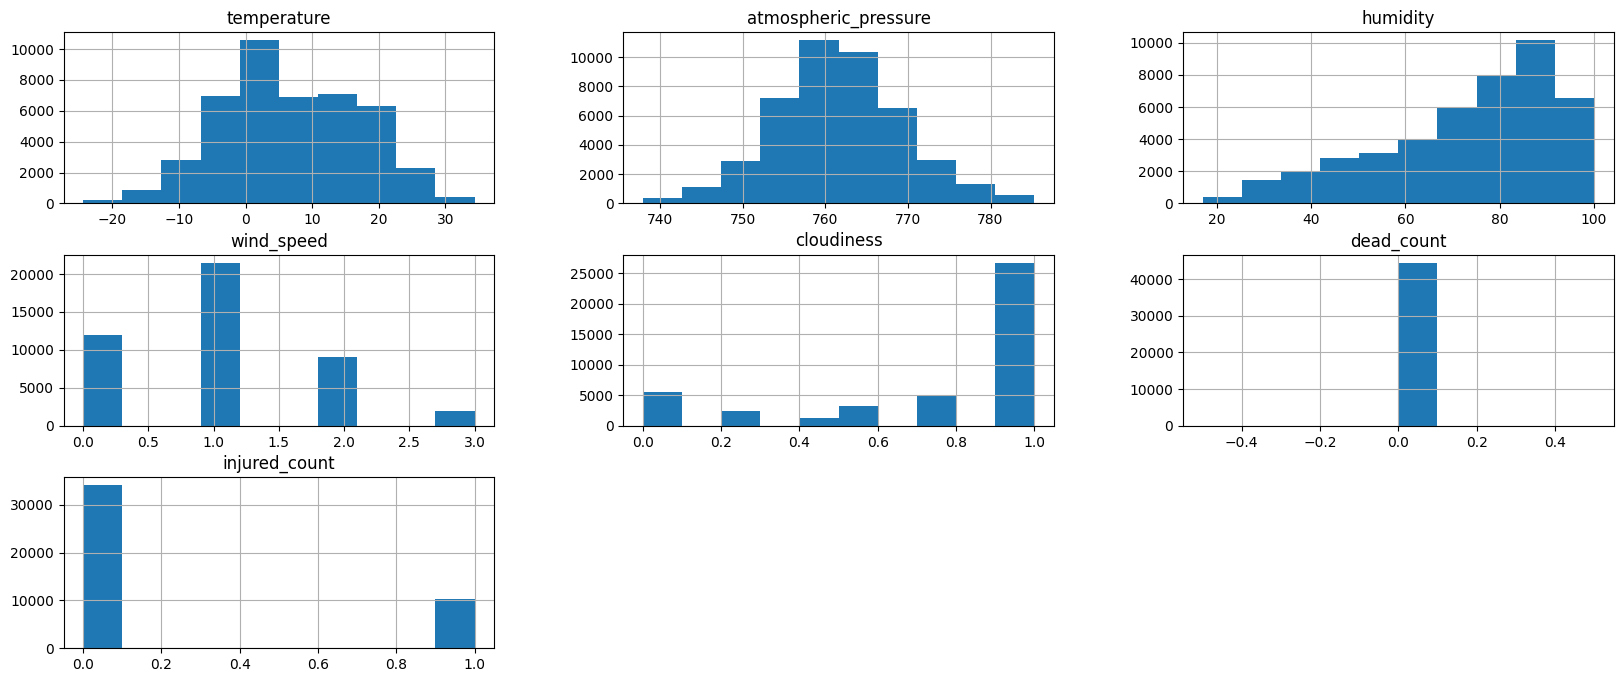

In [335]:
df[num_features].hist(figsize=(20, 8))

plt.show()

#### Енкодинг

In [336]:
categorial_features = df.select_dtypes(include=[object]).columns # type: ignore

df[categorial_features]

,join_key,region_x,direction_of_the_wind,weather_conditions
31939,Север42736,Север,ЗЮЗ,Дымка.
31941,"Север42736,125",Север,З,Дымка.
31943,"Север42736,25",Север,З,Дымка.
31945,"Север42736,375",Север,З,Дымка.
31947,"Север42736,5",Север,ЗЮЗ,Морось незамерзающая непрерывная слабая в срок...
...,...,...,...,...
78720,"Северо-запад44561,375",Северо-запад,СЗ,Дымка.
78721,"Северо-запад44561,5",Северо-запад,ЮЮВ,Дымка.
78722,"Северо-запад44561,625",Северо-запад,ЮВ,
78723,"Северо-запад44561,75",Северо-запад,ЮВ,Дымка.


In [337]:
df['direction_of_the_wind'].unique()

array(['ЗЮЗ', 'З', 'Штиль, безветрие', 'Ю', 'ЮЗ', 'ЮЮЗ', 'ЮЮВ', 'ЗСЗ',
       'ССЗ', 'С', 'ЮВ', 'СЗ', 'ВСВ', 'ВЮВ', 'В', 'ССВ', 'СВ',
       'Переменное направление'], dtype=object)

In [338]:
OHE_features = ['region_x', 'direction_of_the_wind']

df = pd.get_dummies(df, columns=OHE_features, drop_first=True, dtype='int64')

In [339]:
label_encoder = LabelEncoder()

df['weather_conditions'] = label_encoder.fit_transform(df['weather_conditions'])

In [340]:
df.head(5)

,join_key,datetime_x,year,month,temperature,atmospheric_pressure,humidity,wind_speed,cloudiness,weather_conditions,...,direction_of_the_wind_СВ,direction_of_the_wind_СЗ,direction_of_the_wind_ССВ,direction_of_the_wind_ССЗ,"direction_of_the_wind_Штиль, безветрие",direction_of_the_wind_Ю,direction_of_the_wind_ЮВ,direction_of_the_wind_ЮЗ,direction_of_the_wind_ЮЮВ,direction_of_the_wind_ЮЮЗ
31939,Север42736,2017-01-01 00:00:00,2017,1,0.9,755.2,96.0,1.0,1.0,23,...,0,0,0,0,0,0,0,0,0,0
31941,"Север42736,125",2017-01-01 03:00:00,2017,1,1.3,754.3,96.0,2.0,1.0,23,...,0,0,0,0,0,0,0,0,0,0
31943,"Север42736,25",2017-01-01 06:00:00,2017,1,1.3,753.0,97.0,2.0,1.0,23,...,0,0,0,0,0,0,0,0,0,0
31945,"Север42736,375",2017-01-01 09:00:00,2017,1,1.6,752.7,96.0,1.0,1.0,23,...,0,0,0,0,0,0,0,0,0,0
31947,"Север42736,5",2017-01-01 12:00:00,2017,1,1.9,752.4,96.0,2.0,1.0,63,...,0,0,0,0,0,0,0,0,0,0


In [341]:
df.drop(columns=['join_key'], axis=1, inplace=True)

In [342]:
# TODO: datetime_x разобрать на часы, и месяцы, дтп зимой и ночью проще получить

In [343]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

c:\Users\jsink\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\io\formats\style.py:3819: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\jsink\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\io\formats\style.py:3820: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,datetime_x,year,month,temperature,atmospheric_pressure,humidity,wind_speed,cloudiness,weather_conditions,dead_count,injured_count,region_x_Северо-восток,region_x_Северо-запад,direction_of_the_wind_ВСВ,direction_of_the_wind_ВЮВ,direction_of_the_wind_З,direction_of_the_wind_ЗСЗ,direction_of_the_wind_ЗЮЗ,direction_of_the_wind_Переменное направление,direction_of_the_wind_С,direction_of_the_wind_СВ,direction_of_the_wind_СЗ,direction_of_the_wind_ССВ,direction_of_the_wind_ССЗ,"direction_of_the_wind_Штиль, безветрие",direction_of_the_wind_Ю,direction_of_the_wind_ЮВ,direction_of_the_wind_ЮЗ,direction_of_the_wind_ЮЮВ,direction_of_the_wind_ЮЮЗ
datetime_x,1.000000,0.981512,0.066741,-0.022156,-0.015323,0.005389,-0.050323,-0.006156,0.039665,nan,-0.075300,-0.001397,0.002062,0.011956,0.028031,-0.011636,-0.036281,0.009880,0.008801,-0.025239,0.000444,-0.008792,-0.025098,-0.007423,0.057279,-0.002837,-0.020047,0.015905,-0.043549,0.010075
year,0.981512,1.000000,-0.124816,-0.065975,-0.040048,-0.016578,-0.032069,-0.013332,0.051816,nan,-0.093168,-0.002367,0.002545,0.016171,0.023333,-0.007617,-0.039337,0.018509,0.008018,-0.014579,0.006584,-0.008402,-0.017929,-0.000049,0.044650,-0.005227,-0.021300,0.020275,-0.050867,0.010574
month,0.066741,-0.124816,1.000000,0.231904,0.128502,0.116188,-0.095001,0.037534,-0.064770,nan,0.094438,0.005110,-0.002602,-0.020979,0.023879,-0.023036,0.017537,-0.046150,0.003250,-0.056310,-0.030798,-0.002804,-0.036846,-0.038479,0.064535,0.013965,0.007690,-0.023586,0.040220,-0.002383
temperature,-0.022156,-0.065975,0.231904,1.000000,-0.140481,-0.439943,-0.103356,-0.185942,-0.279595,nan,0.089768,0.006163,-0.015828,0.029807,0.012195,-0.041559,0.052787,-0.062996,0.006709,-0.030266,0.027222,0.034861,0.010689,-0.010954,0.079028,-0.028220,-0.053612,-0.027984,-0.044746,-0.015005
atmospheric_pressure,-0.015323,-0.040048,0.128502,-0.140481,1.000000,-0.170271,-0.107051,-0.293772,-0.240989,nan,0.030882,0.004640,-0.001774,0.048904,0.047231,-0.098290,-0.076312,-0.089252,0.001450,0.074009,0.042188,-0.055441,0.058414,-0.010940,0.114538,-0.057755,0.009595,-0.057370,-0.013419,-0.061249
humidity,0.005389,-0.016578,0.116188,-0.439943,-0.170271,1.000000,-0.173015,0.409557,0.406945,nan,-0.087185,0.001577,-0.002385,-0.058059,-0.017349,0.007507,-0.058885,0.017363,-0.008312,-0.058129,-0.062085,-0.067034,-0.050044,-0.079225,0.167548,-0.006209,0.032334,-0.016714,0.024575,-0.009237
wind_speed,-0.050323,-0.032069,-0.095001,-0.103356,-0.107051,-0.173015,1.000000,0.155327,0.096249,nan,0.047939,0.069034,-0.141865,0.044874,0.078313,0.077573,0.090458,0.050430,-0.000193,0.199416,0.060247,0.149685,0.129775,0.184839,-0.769922,0.081158,0.134272,0.021441,0.198404,0.016112
cloudiness,-0.006156,-0.013332,0.037534,-0.185942,-0.293772,0.409557,0.155327,1.000000,0.363828,nan,-0.026249,-0.002197,0.004234,-0.017138,0.023339,0.043296,-0.001614,0.045109,-0.009435,-0.038314,-0.017356,0.005193,-0.018445,-0.001258,-0.175629,0.071404,0.069458,0.033530,0.084266,0.042384
weather_conditions,0.039665,0.051816,-0.064770,-0.279595,-0.240989,0.406945,0.096249,0.363828,1.000000,nan,-0.022809,-0.011473,0.020841,-0.005746,0.016831,0.023151,0.001254,0.016487,-0.004754,0.003921,-0.011982,0.011226,-0.001644,0.027183,-0.080842,0.002135,0.041100,-0.002927,0.029610,-0.002368
dead_count,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


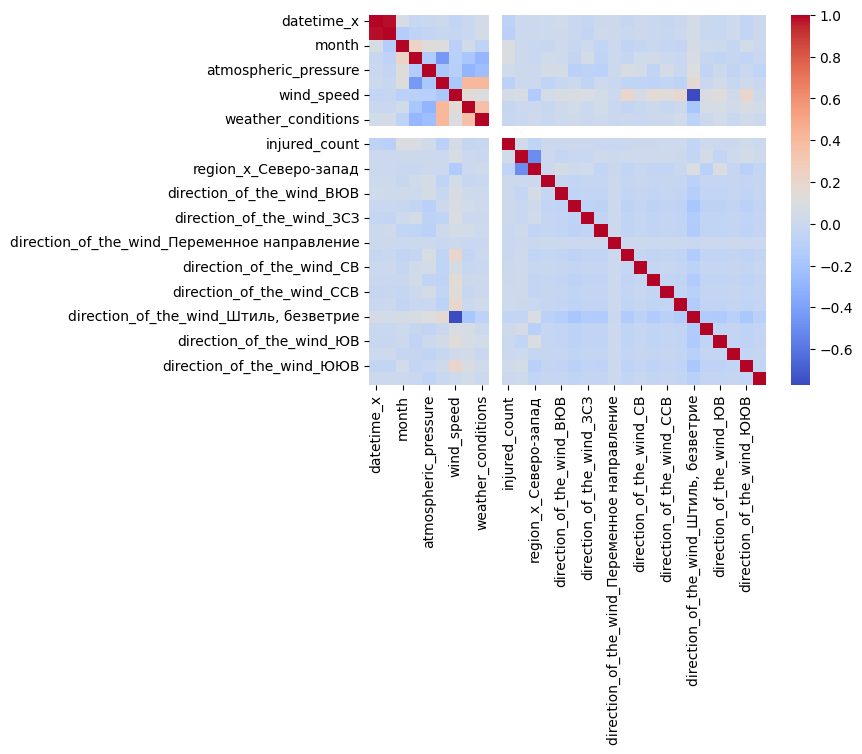

In [344]:
sns.heatmap(corr, cmap="coolwarm")
plt.show()

#### Разделение на выборки

In [345]:
# Разделение на признаки X и целевую переменную y
TARGET = 'injured_count'

X = df.drop(TARGET, axis=1)
y = df[TARGET]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Вывод размеров выборок
print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (35552, 29)
Размер тестовой выборки: (8888, 29)


AutoML

In [346]:
# automl = autosklearn.classification.AutoSklearnClassifier()
# automl.fit(X, y)

# print(automl.sprint_statistics())
# print(automl.show_models())

In [347]:
# tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2)
# tpot.fit(X, y)

# print(tpot.score(X, y))

# tpot.export('best_model.py')

NameError: name 'TPOTClassifier' is not defined

In [ ]:
# Инициализация PyCaret
setup(data, target='target_variable')

# Сравнение всех доступных моделей
compare_models()

# Создание и обучение наилучшей модели
best_model = create_model()

# Оценка модели и вывод результатов
evaluate_model(best_model)